according## Step by Step Multi Arm Bandit based on Thompson Sampling

Content created by:

Mario A. Vinasco and Sneha Ravi 
(Marketing Analytics at Uber Technologies)

Multi Arm Bandit (MAB) experimentation is a type of dynamic testing that allocates new treatment units to the
'winning' arms.

In this particular case, we are interested in testing 10 subject lines and evaluate which one works best.

We conduct the experiment for several rounds (each round is sent to new users) and re allocate the proportion of users that receive each subject line according to a Thompson Sampling allocation.


In [262]:
import scipy.stats as stats
import numpy as np
import pymc3 as pm
import pandas as pd
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
%matplotlib inline

### The data for this tutorial was simulated from a Subject Line email campaign with 10 arms
Data source: multi_arm_bandit_example_distrib.csv 

Simulated data of approximately 2000 users in each arm with open rates around 33%

In [524]:
# READ DATA
experiment_df = pd.read_csv('multi_arm_bandit_example_distrib.csv')
experiment_df.drop(['Unnamed: 0'], axis=1, inplace=True)
experiment_df.head(2)

,date,email_opened,response,treatment_group_key,UUID_hash2
0,2017-11-22,0.0,0,t10,7046538529512660515
1,2017-11-26,0.0,0,t4,2553545477797482936


In [525]:
experiment_df[['UUID_hash2', 'date']].groupby('date').count()

,UUID_hash2
date,
2017-11-22,1996
2017-11-23,3107
2017-11-24,4250
2017-11-25,5462
2017-11-26,5421


In [526]:
# drop un-needed columns
experiment_df.drop(['email_opened'], axis=1, inplace=True)
experiment_df.drop(['date'], axis=1, inplace=True)
experiment_df.drop(['UUID_hash2'], axis=1, inplace=True)

In [267]:
gb = experiment_df.groupby('treatment_group_key')

In [531]:
gb.agg(['sum', 'count'])    
# The SUM produces the number of emails opened
# The COUNT produces the total emails sent

response      
                         sum count
treatment_group_key               
t1                       679  2051
t10                      642  1953
t2                       718  2072
t3                       671  2020
t4                       659  2018
t5                       726  2100
t6                       672  1968
t7                       652  1996
t8                       698  2015
t9                       692  2043

### Simulation Set Up

In [529]:
n_bandits = gb.size().shape[0]
test_labels = [i for i in gb.size().index]

# number of iterations in simulation:  reccomended 20000
mcmc_iters = 25000

### Thompson Sampling

In the above data, some arms have slightly better open rates (successes) than others. These 'wining' arms will get more weigth allocation in the next round.

The allocations are deciding by simulating a Beta distribution with alpha=successes, beta=failures


In [509]:
# Beta distributions simulation
# Generates Beta arrays, 1 per bandit (each have a different alpha/beta params])

alphas = gb.sum().values                 # number of successes
betas = (gb.count() - gb.sum()).values   # failures == total - successes

beta_dist = np.empty(shape=(mcmc_iters, n_bandits))

for n in range(n_bandits):
    beta_dist[:, n] = np.random.beta(np.asscalar(alphas[n]), np.asscalar(betas[n]), size=(mcmc_iters))

In [510]:
# Calculates the MAX per row
betas_argmax = np.zeros(shape=mcmc_iters)
betas_argmax = beta_dist.argmax(1)

In [511]:
# creates 1-hot encoded matrix with 1 at the position indicated by betas_argmax
betas_mask = np.zeros(shape=(mcmc_iters, n_bandits))
betas_mask[np.arange(mcmc_iters), betas_argmax] = 1

In [512]:
# posterior allocations
# Multiply betas * betas_max and sums by bandit

new_bandits = sum(betas_mask * beta_dist)
sample_sizes = alphas.ravel() + betas.ravel()
posteriors_nume = np.sqrt(sample_sizes) * new_bandits
posteriors_denom = sum(posteriors_nume)
posteriors = posteriors_nume / posteriors_denom

In [520]:
# old allocations
old_prob = gb.count().values / sum(gb.count().values)

### Visualization of next round allocations

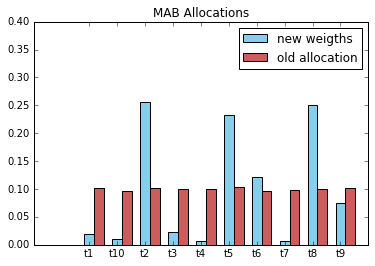

In [575]:
# Viz of Allocation change
ind = np.arange(n_bandits)  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, posteriors, width, 
                color='SkyBlue', label='new weigths')
rects2 = ax.bar(ind + width/2, old_prob, width,
                color='IndianRed', label='old allocation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('MAB Allocations')
ax.set_xticks(ind)
ax.set_xticklabels(test_labels)
ax.legend()

ax.set_ylim(0, 0.4)  # vertical axis max value

plt.show()

### Potential Value Remaining

source: https://support.google.com/analytics/answer/2846882?hl=en

This metric can be used as stop criteria for the MAB.

The metric is calculated as distribution of the differences of the overall winning arm versus the highest arm in each simulated row; then the 95th percentile is taken as the PVR.

STOP when PVR is 'Sufficiently' low 

In [545]:
# previously, we calculated the argmax per row, or the arm that has the largest value in each row of the simulation
# betas_argmax : has the index of the largest value
# betas_mask: 1-hot encoded matrix

winning_arm_idx = posteriors.argmax()
pvrs = np.zeros(shape=mcmc_iters)

max_elems = np.sum(beta_dist * betas_mask, axis=1)
pvrs = max_elems - beta_dist[:, winning_arm_idx] 


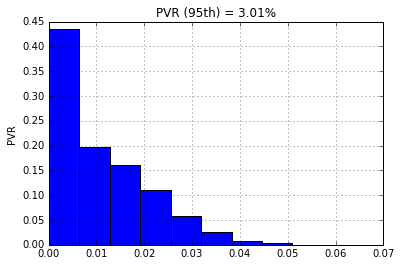

In [593]:
results, edges = np.histogram(pvrs, normed=True)
binWidth = edges[1] - edges[0]
prc_95 = np.percentile(pvrs, 95) * 100
legend = 'PVR (95th) = {:.2f}%'.format(prc_95)
plt.ylabel('PVR')
plt.title(legend)
plt.grid(True)

plt.bar(edges[:-1], results*binWidth, binWidth)

plt.show()

## Appendix

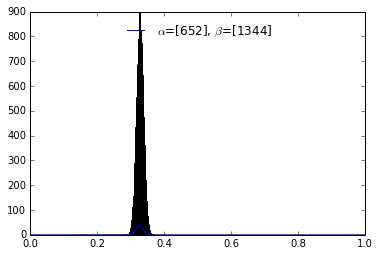

In [574]:
# Visualize simulated Beta vs actiual Beta
n = 7 # pick any arm
y = beta_dist[:,n]
x = np.linspace(0.0, 1.0, mcmc_iters)
fig, ax = plt.subplots()

f = lambda a, b : stats.beta.pdf(x, a, b)
plot_pdf = lambda a, b : ax.plot(x, f(a,b), label=r'$\alpha$={0}, $\beta$={1}'.format(a,b))

plot_pdf(alphas[n], betas[n])

ax.hist(y, bins=100)
plt.legend(loc='upper center', frameon=False)
plt.show()

In [349]:
# approximation to avoid a second matrix
# multiply the maxarg by factor, sum across and divide by same factor
# all matrix elements lower than argmax will contribute very little
beta_dist[np.arange(mcmc_iters), betas_argmax] *= 10000
sum(beta_dist)/1000

array([  4.94977012e-03,   4.94859281e-03,   1.78220584e+01,
         5.00472101e-03,   4.93616358e-03,   1.08703894e+01,
         7.24382018e+00,   4.95478630e-03,   1.77991550e+01,
         5.10369702e-03])

In [355]:
beta_dist[np.arange(mcmc_iters), betas_argmax] /= 10000